In this code, I want to compare slope constrained and linear spline model. for the former, i will set the same grid which i will use for the latter. thus both the models would be equivalent and ideally should behave the same!

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Dataset

from activations.linearspline_slope_constraint import LinearSplineSlopeConstrained
from activations.linearspline import LinearSpline

import os
import json
from tqdm import tqdm

# dataset (2 moons)
from sklearn.datasets import make_moons


import torch.optim as optim
from torch.nn.utils import clip_grad_norm_

In [2]:
# Function to generate data from a 1D Gaussian distribution
def generate_gaussian_data(mean, 
            std_dev, total_samples, train_ratio=0.6, val_ratio=0.2):
    """
    Generate training, validation, and test datasets from a 1D Gaussian distribution.

    Parameters:
    - mean: Mean of the Gaussian distribution
    - std_dev: Standard deviation of the Gaussian distribution
    - total_samples: Total number of samples to generate
    - train_ratio: Proportion of data to use for training (default is 70%)
    - val_ratio: Proportion of data to use for validation (default is 15%)

    Returns:
    - train_data: Training set
    - val_data: Validation set
    - test_data: Test set
    """
    # Generate data
    data = np.random.normal(loc=mean, scale=std_dev, size=total_samples)

    # Shuffle data
    np.random.shuffle(data)

    # Split data based on ratios
    train_end = int(total_samples * train_ratio)
    val_end = train_end + int(total_samples * val_ratio)

    train_data = data[:train_end]
    val_data = data[train_end:val_end]
    test_data = data[val_end:]

    return train_data, val_data, test_data

# Function to convert datasets into DataLoaders
def create_dataloaders(train_data, val_data, test_data, batch_size=32):
    """
    Convert numpy arrays into PyTorch DataLoaders.

    Parameters:
    - train_data: Training dataset (numpy array)
    - val_data: Validation dataset (numpy array)
    - test_data: Test dataset (numpy array)
    - batch_size: Batch size for the DataLoaders

    Returns:
    - train_loader: DataLoader for training data
    - val_loader: DataLoader for validation data
    - test_loader: DataLoader for test data
    """
    # Convert numpy arrays to PyTorch tensors
    train_tensor = torch.tensor(train_data, dtype=torch.float32)
    val_tensor = torch.tensor(val_data, dtype=torch.float32)
    test_tensor = torch.tensor(test_data, dtype=torch.float32)

    # Create TensorDatasets
    train_dataset = TensorDataset(train_tensor)
    val_dataset = TensorDataset(val_tensor)
    test_dataset = TensorDataset(test_tensor)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader





In [3]:
# Function to generate data from a 1D Laplace distribution
def generate_laplace_data(mean, scale, total_samples, num_test_data=15000, train_ratio=0.75, val_ratio=0.25):
    """
    Generate training, validation, and test datasets from a 1D Laplace distribution.

    Parameters:
    - mean: Mean (location parameter) of the Laplace distribution
    - scale: Scale (diversity) parameter of the Laplace distribution
    - total_samples: Total number of samples (excluding test data)
    - num_test_data: Number of samples to reserve for the test dataset
    - train_ratio: Proportion of remaining data to use for training (default is 70%)
    - val_ratio: Proportion of remaining data to use for validation (default is 30%)

    Returns:
    - train_data: Training set
    - val_data: Validation set
    - test_data: Test set
    """
    # Generate full dataset including test data
    total_data = np.random.laplace(loc=mean, scale=scale, size=total_samples + num_test_data)

    # Shuffle data
    np.random.shuffle(total_data)

    # Separate test data
    test_data = total_data[:num_test_data]
    remaining_data = total_data[num_test_data:]

    # Split remaining data into train and validation sets
    train_end = int(len(remaining_data) * train_ratio)
    
    train_data = remaining_data[:train_end]
    val_data = remaining_data[train_end:]

    return train_data, val_data, test_data

In [4]:
# GENERATE GAUSSIAN DATA
# mean = 3.0#2
# std_dev = 3.0
# total_samples = 8000#50000

# train_data, val_data, test_data = generate_gaussian_data(mean, std_dev, total_samples)

# GENERATE LAPLACE DATA
mean = 5
scale = 6
total_samples = 70000
# for each minibatch, new data
#
train_data, val_data, test_data = generate_laplace_data(mean, scale, total_samples)
print(f"Train size: {len(train_data)}, Val size: {len(val_data)}, Test size: {len(test_data)}")


Train size: 52500, Val size: 17500, Test size: 15000


In [5]:
# Reshape data before returning
train_data = train_data.reshape(-1, 1)
val_data = val_data.reshape(-1, 1)
test_data = test_data.reshape(-1, 1)

# Convert to DataLoaders
batch_size = 20#16#32#16#16#32
train_loader, val_loader, test_loader = create_dataloaders(train_data, val_data, test_data, batch_size)

# Print dataset sizes
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

Training set size: 52500
Validation set size: 17500
Test set size: 15000


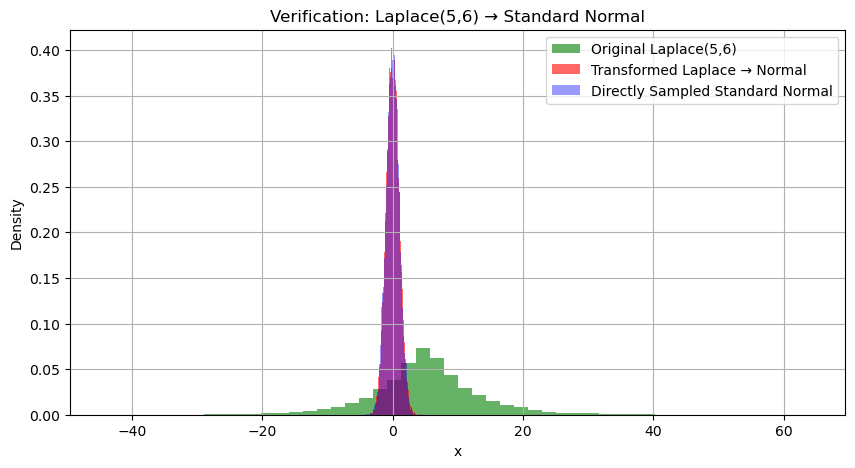

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, laplace

# Transformation function for Laplace(mu, b) → Standard Normal
def laplace_to_normal(x, mu=0, b=1):
    """
    Transforms a Laplace(mu, b) distributed variable into a standard normal.
    
    Args:
    - x: Input Laplace-distributed samples.
    - mu: Mean of the Laplace distribution.
    - b: Scale parameter of the Laplace distribution.
    
    Returns:
    - Transformed values following a standard normal distribution.
    """
    # Compute shifted & scaled Laplace CDF
    F_X = np.where(x < mu, 0.5 * np.exp((x - mu) / b), 1 - 0.5 * np.exp(-(x - mu) / b))
    # Apply inverse CDF of standard normal
    return norm.ppf(F_X)

# Step 1: Sample from a Laplace distribution with custom mean and scale
num_samples = 10000
mu, b = mean, scale  # Example: Laplace(2, 1.5)
laplace_samples = laplace.rvs(loc=mu, scale=b, size=num_samples)

# Step 2: Apply transformation
normal_samples_transformed = laplace_to_normal(laplace_samples, mu, b)

# Step 3: Sample directly from standard normal for comparison
normal_samples_direct = norm.rvs(size=num_samples)

# Step 4: Plot histograms before and after transformation
plt.figure(figsize=(10, 5))

# Original Laplace distribution before transformation
plt.hist(laplace_samples, bins=50, density=True, alpha=0.6, color='g', label=f'Original Laplace({mu},{b})')

# Transformed Laplace samples
plt.hist(normal_samples_transformed, bins=50, density=True, alpha=0.6, color='r', label='Transformed Laplace → Normal')

# Direct Standard Normal samples
plt.hist(normal_samples_direct, bins=50, density=True, alpha=0.4, color='b', label='Directly Sampled Standard Normal')

# Labels and legend
plt.title(f"Verification: Laplace({mu},{b}) → Standard Normal")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()


In [7]:
from scipy.stats import norm



def transformation_laplace_to_std_normal(mu=0, b=1, x_range=(-10,10), num_points=41):
    # Define x values
    x = np.linspace(x_range[0], x_range[1], num_points)

    # Compute Laplace CDF
    F_X = np.where(x < mu, 0.5 * np.exp((x - mu) / b), 1 - 0.5 * np.exp(-(x - mu) / b))

    # Compute the transformation function T(x)
    T_x = norm.ppf(F_X)

    return x,T_x

def plot_transformation(mu=0, b=1, x_range=(-5, 5), num_points=1000):
    """
    Plots the transformation function T(x) = Φ⁻¹(F_X(x)) that maps a 
    Laplace(mu, b) distributed variable to a standard normal.
    
    Args: 
    - mu: Mean of the Laplace distribution.
    - b: Scale parameter of the Laplace distribution.
    - x_range: Tuple defining the range of x values for the plot.
    - num_points: Number of points in the plot.
    
    Returns:
    - A plot of T(x) = Φ⁻¹(F_X(x)).
    """
    x,T_x = transformation_laplace_to_std_normal(mu=mu, b=b, x_range=x_range, num_points=num_points)

    # Plot T(x)
    plt.figure(figsize=(7, 5))
    plt.plot(x, T_x, label=r'$T(x) = \Phi^{-1}(F_X(x))$', color='b')
    plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
    plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
    plt.xlabel("$x$")
    plt.ylabel("$T(x)$")
    plt.title(f"Transformation Function from Laplace({mu}, {b}) to Standard Normal")
    plt.legend()
    plt.grid(which='both')  # Optional: Add a grid
    plt.minorticks_on()

    # Bold major grid lines
    plt.grid(which='major', linestyle='-', linewidth=1.5, alpha=0.9, color='black')

    # Light minor grid lines
    plt.grid(which='minor', linestyle=':', linewidth=0.7, alpha=0.5, color='gray')
    plt.show()


In [8]:
# Now i need to train this model using NLL loss
def nll_loss(z, det_jacobian, alpha_nll=1,return_indiv_loss=0):
    '''
    z :  tensor z in latent space
    det_jacobian : det(J_{f}(xi)) for each xi (we will take abs in this fn later)
    '''
    loss_1 = 0.5 * torch.sum(z**2)
    # print("det jacobian is:"); print(det_jacobian)
    #loss_2 = torch.sum(torch.log(torch.abs(det_jacobian)))
    loss_2 = torch.sum(torch.log(det_jacobian)) # coy slopes are always positive
    # print("torch.log(torch.abs(det_jacobian):",torch.log(torch.abs(det_jacobian)))
    # print(f"loss 1 is: {loss_1} and loss 2 is: {loss_2}")
    dataset_length = z.size(0)
    loss_with_alpha = (loss_1-loss_2)/ dataset_length # earlier i have some multiplicative alpha here but i removed it as we dont need it
    loss_normal = (loss_1 - loss_2)/ dataset_length
    if return_indiv_loss:
        return loss_with_alpha, loss_normal,loss_1/dataset_length, loss_2/dataset_length
    return loss_with_alpha, loss_normal

In [9]:
def plot_multiple_histogram(list_of_inputs, labels_list):
    # add a code line here: if the inputs are not numpy, convert them to numpy
    plt.figure(figsize=(5, 5))

    for i in range(0,len(list_of_inputs)):
        # Histogram for the code samples
        plt.hist(list_of_inputs[i], bins=50, alpha=0.4, 
                density=True, label=labels_list[i])
        plt.legend()

In [10]:
# plot splines with annotations
def plot_with_annotations(x, y,label="with const coeffs",
                title="Plot with (x, y) Annotations", 
            xlabel="X-axis", ylabel="Y-axis",
            txt_color="red", annotate=1, style="-o"):
    """
    Plot x and y values with (x, y) annotations.

    Args:
    - x (array-like): Array of x-values.
    - y (array-like): Array of y-values.
    - title (str): Title of the plot.
    - xlabel (str): Label for the X-axis.
    - ylabel (str): Label for the Y-axis.

    Returns:
    - None
    """
    plt.plot(x, y, style,label=label)  # Plot the points with markers and lines

    # Annotate each point with its (x, y) coordinates
    if annotate:
        for x_val, y_val in zip(x, y):
            plt.annotate(
                f"({x_val:.2f}, {y_val:.2f})",  # Format to 2 decimal places
                (x_val, y_val),  # The point to annotate
                textcoords="offset points",  # Offset the text slightly
                xytext=(5, 5),  # Offset (5, 5) pixels
                fontsize=8,  # Font size of the annotation
                color=txt_color # Optional: text color
            )
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(which='both')  # Optional: Add a grid
    plt.minorticks_on()

    # Define x values
    x = np.linspace(-40, 40, 1000)

    # Compute Laplace CDF
    F_X = np.where(x < mu, 0.5 * np.exp((x - mu) / b), 1 - 0.5 * np.exp(-(x - mu) / b))

    # Compute the transformation function T(x)
    T_x = norm.ppf(F_X)

    # Plot T(x)
    plt.plot(x, T_x, label=r'$T(x) = \Phi^{-1}(F_X(x))$', color='b')

    # Bold major grid lines
    plt.grid(which='major', linestyle='-', linewidth=1.5, alpha=0.9, color='black')

    # Light minor grid lines
    plt.grid(which='minor', linestyle=':', linewidth=0.7, alpha=0.5, color='gray')
    plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
    plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
    plt.legend()

In [11]:
def TV2(model, device_info):
    """
    Computes the sum of the TV(2) (second-order total-variation)
    semi-norm of all linearspline activations in the network.

    Returns:
        tv2 (0d Tensor):
            tv2 = sum(TV(2))
    """
    tv2 = torch.Tensor([0.]).to(device_info)

    for module in model.modules():
        if isinstance(module, LinearSplineSlopeConstrained):
            module_tv2 = module.totalVariation(mode='additive')
            tv2 = tv2 + module_tv2.norm(p=1)
    # print("tv2 is:"); print(tv2)

    return tv2[0] 

In [12]:
# train and evaluate fn.
def train_and_evaluate(
    model, train_loader, val_loader, 
    lambda_tv2=1e-4, num_epochs=10, 
    lr=0.001, print_after=1, tv2_regulation=False, 
    scheduler_type="StepLR", step_size=5, gamma=0.1,
    alpha_nll=1,
    track_coefficients = False, type_model="ls"#"scls"
):
    """
    Train the RealNVP model and evaluate on a validation dataset.

    Args:
    - model: The NF model to be trained.
    - train_loader (DataLoader): DataLoader for the training dataset.
    - val_loader (DataLoader): DataLoader for the validation dataset.
    - num_epochs (int): Number of training epochs.
    - lr (float): Learning rate for the optimizer.
    - print_after (int): Number of epochs after which to print the training and validation loss.
    - scheduler_type (str): Type of scheduler to use ("StepLR", "ExponentialLR", etc.).
    - step_size (int): Step size for the StepLR scheduler (if applicable).
    - gamma (float): Multiplicative factor for learning rate decay.

    Returns:
    - train_losses (list): List of training losses for each epoch.
    - val_losses (list): List of validation losses for each epoch.
    """

    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Define the scheduler
    if scheduler_type == "StepLR":
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    elif scheduler_type == "ExponentialLR":
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    elif scheduler_type == "ReduceLROnPlateau":
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=gamma, patience=2)
    else:
        raise ValueError("Unsupported scheduler type. Choose from 'StepLR', 'ExponentialLR', or 'ReduceLROnPlateau'.")

    train_losses = []  # List to store training losses
    loss_1_list=[]
    loss_2_list=[]
    val_losses = []  # List to store validation losses
    model_params_history = []  # To store model state_dicts for each epoch
    # Save a copy of the model's state_dict
    model_params_history.append({k: v.clone() for k, v in model.state_dict().items()})

    if track_coefficients:
        coeffs_evol=[]
        slope_const_coeffs_evol=[]

    for epoch in tqdm(range(num_epochs), desc="Training Progress"):
        total_train_loss = 0.0
        total_train_and_regul_loss=0.0
        total_loss_1=0.0; total_loss_2=0.0

        if track_coefficients:
            # do I really need to change them to numpy?
            coeffs=model.coefficients_vect.detach().numpy()
            if type_model=="ls":  #activations.linearspline_slope_constraint.LinearSplineSlopeConstrained
                slope_const_coeffs = model.lipschitz_coefficients_vect.detach().numpy()
            elif type_model== "scls":
                slope_const_coeffs = model.slope_constrained_coefficients_vect.detach().numpy()
            coeffs_evol.append(list(coeffs))
            slope_const_coeffs_evol.append(list(slope_const_coeffs))

        # Training phase
        model.train()  # Set the model to training mode
        for data in train_loader:
            inputs = data[0]  # data is a list containing the tensor [tensor()]
            # print(f"shape of inputs: {inputs.size()}")
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass (encoding)
            encoded = model(inputs)

            # Loss calculation
            ## Normal loss term
            train_loss, loss_normal, loss_1, loss_2 = nll_loss(encoded, model.grad_x_temp,
                                            alpha_nll=alpha_nll,return_indiv_loss=1)

            ### TV2 regularisation term
            if tv2_regulation:
                tv2_regul = TV2(model, model.coefficients_vect.device)
            # print(f"tv2 regul: {tv2_regul}")
            ## Total loss
            if tv2_regulation:
                total_loss = train_loss + lambda_tv2 * tv2_regul
            else:
                total_loss = train_loss
            # print(f"lambda_tv2 {(lambda_tv2 )} x tv2_regul: {lambda_tv2 * tv2_regul}")
            # Backward pass (gradient computation)
            total_loss.backward()

            # Update weights
            optimizer.step()
            total_train_and_regul_loss += total_loss.item()
            total_train_loss += train_loss.item()#loss_normal.item()#train_loss.item()
            total_loss_1 +=loss_1.item()
            total_loss_2 += loss_2.item()# initially this + was missing
        # Step the scheduler
        if scheduler_type != "ReduceLROnPlateau":
            scheduler.step()
        else:
            scheduler.step(total_train_loss / len(train_loader))
        
        # Save a copy of the model's state_dict
        model_params_history.append({k: v.clone() for k, v in model.state_dict().items()})

        # i commented it because i also want to see how coefficients look before the training begins
        # if track_coefficients:
        #     # do I really need to change them to numpy?
        #     coeffs=model.coefficients_vect.detach().numpy()
        #     slope_const_coeffs = model.slope_constrained_coefficients_vect.detach().numpy()
        #     coeffs_evol.append(list(coeffs))
        #     slope_const_coeffs_evol.append(list(slope_const_coeffs))

        # Average training loss for the epoch
        average_train_loss = total_train_loss / len(train_loader)
        avg_train_and_regul_loss = total_train_and_regul_loss / len(train_loader)
        avg_loss_1 = total_loss_1/len(train_loader)
        avg_loss_2 = total_loss_2/len(train_loader)
        # Validation phase
        if val_loader is not None:
            model.eval()  # Set the model to evaluation mode
            total_val_loss = 0.0
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs = val_data[0]

                    # Forward pass (encoding) for validation
                    val_encoded = model(val_inputs)

                    # Loss calculation for validation
                    val_loss,_ = nll_loss(val_encoded, model.grad_x_temp)

                    total_val_loss += val_loss.item()

            # Average validation loss for the epoch
            average_val_loss = total_val_loss / len(val_loader)

            # Print training and validation losses together
            if (epoch + 1) % print_after == 0:
                print(
                    f"Epoch {epoch + 1}/{num_epochs}, "
                    f" train NLL+{lambda_tv2 * int(tv2_regulation)}XTV2: {avg_train_and_regul_loss}, "
                    f"data avg loss-1: {avg_loss_1} ,"
                    f"data avg loss-2: {avg_loss_2} ,"
                    f"Training NLL Loss: {average_train_loss}, "
                    f"Validation NLL Loss: {average_val_loss}, "
                    f"LR: {scheduler.get_last_lr()[0]}"
                )

            # Append losses to the lists
            train_losses.append(average_train_loss)
            val_losses.append(average_val_loss)

        # Set the model back to training mode
        model.train()

    print("Training complete")

    if track_coefficients:
        return train_losses, val_losses,model_params_history, coeffs_evol, slope_const_coeffs_evol
    return train_losses, val_losses,model_params_history


In [13]:
def plot_loss_curves(train_loss, val_loss,title, log_scale=False):
    ''' plots train and val loss'''
    plt.figure()
    plt.plot(train_loss,"-o" ,label="train")
    plt.plot(val_loss, "-o",label = "val")
    if log_scale:
        plt.yscale("log")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title(title)
    plt.legend()
    plt.show()

In [14]:
def plot_coefficients_evolution(num_coeffs, coeffs, slope_constr_coeffs, log_scale=0):
    ''' 
    coeffs = List[list]: 
        e.g. [ [c1(t0),c2(t0),c3(t0)], [c1(t1),c2(t1),c3(t1)] ,..., 
        [c1(tn),c2(tn),c3(tn)]]
    slope_constr_coeffs = List[list]
    '''
    # Calculate grid dimensions dynamically
    cols = math.ceil(math.sqrt(num_coeffs))  # Number of columns
    rows = math.ceil(num_coeffs / cols)      # Number of rows
    
    fig, axs = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axs = axs.flatten()  # Flatten for easier indexing

    for i in range(num_coeffs):
        ax = axs[i]
        ax.plot(coeffs[:, i], "-o", label=f"coeff[{i}]")
        ax.plot(slope_constr_coeffs[:, i], ":o", label=f"slope constr coeff[{i}]")
        ax.set_title(f"Coefficient {i}")
        ax.set_ylabel("Value")
        if log_scale:
            ax.set_yscale("log")
        ax.legend(loc='upper right')
        ax.grid(True)
    
    # Hide unused subplots
    for i in range(num_coeffs, len(axs)):
        axs[i].axis('off')
    
    # Set x-label for bottom row only
    for i in range(len(axs) - cols, len(axs)):
        axs[i].set_xlabel("Training epochs")
    
    fig.suptitle("Evolution of coefficients with training of a spline", y=1.00)
    plt.tight_layout()
    plt.show()

    


In [15]:
# fn to load weights into model. This fn is used later to visualise the code space during training
# to study training dynammics
def load_weights_into_model(model, parameters_dict):
    """
    Loads weights into the SplineNN model using a state_dict-like dictionary.

    Args:
    - model (SplineNN): The model into which weights are to be loaded.
    - parameters_dict (dict): A dictionary of parameters (state_dict format).
      Keys should match those in the model's state_dict.

    Returns:
    None
    """
    # Ensure the keys match between the input dictionary and the model's state_dict
    model_state_dict = model.state_dict()
    
    # Verify all keys are present in the provided parameters
    for key in model_state_dict.keys():
        if key not in parameters_dict:
            raise ValueError(f"Key '{key}' not found in provided parameters.")

    # Load parameters into the model
    for name, param in model_state_dict.items():
        if name in parameters_dict:
            param.data.copy_(parameters_dict[name])
        else:
            raise ValueError(f"Missing parameter for layer: {name}")

    # print("Weights successfully loaded into the model.")

In [16]:
# Visualize the training dynamics in the code space using histograms
def plot_multiple_z_with_normal_1d(models_params, test_data, model, 
                                   num_samples=1000, mean=0, 
                                   std=1, figsize=(10, 10), bins=50,
                                   print_model_params=0, plot_frequency=1):
    """
    Plots multiple 1D histograms of z and 1D normal distribution samples in a grid.

    Args:
    - models_params (list): List of model parameters for each epoch (including initial params).
    - test_data (numpy.ndarray): Test data for encoding.
    - model (torch.nn.Module): The neural network model.
    - num_samples (int): Number of points to sample from the 1D normal distribution.
    - mean (float): Mean of the 1D normal distribution.
    - std (float): Standard deviation of the 1D normal distribution.
    - figsize (tuple): Size of the overall figure.
    - bins (int): Number of bins for the histograms.
    - print_model_params (int): Whether to print model parameters (0 or 1).
    - plot_frequency (int): Frequency of plotting histograms (e.g., every 5 epochs).

    Returns:
    None
    """
    # Filter epochs to plot based on frequency
    epochs_to_plot = [i for i in range(len(models_params)) if i % plot_frequency == 0 or i == 0]
    num_plots = len(epochs_to_plot)
    
    # Prepare the normal distribution samples
    normal_samples = np.random.normal(mean, std, num_samples)
    
    # Create a grid of subplots
    num_rows = int(np.ceil(np.sqrt(num_plots)))
    num_cols = int(np.ceil(num_plots / num_rows))
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()  # Flatten to easily iterate over
    
    test_tensor = torch.tensor(test_data, dtype=torch.float)

    for plot_idx, epoch_idx in enumerate(epochs_to_plot):
        ax = axes[plot_idx]
        
        # Load model weights for the current epoch
        load_weights_into_model(model, models_params[epoch_idx])

        if print_model_params:
            #print(models_params[epoch_idx])
            print(f"slopes: constrrained coeffs: {model.slopes_tensor(for_projected_coeffs=1).detach()}")
        
        # Encode the test data
        with torch.no_grad():
            encoded_test1 = model(test_tensor)
        
        # Plot histogram on the subplot
        ax.hist(normal_samples, bins=bins, color='blue', alpha=0.3, label="Normal Samples", density=True)
        ax.hist(encoded_test1.squeeze().numpy(), bins=bins, color='red', alpha=0.3, label="Encoded z", density=True)
        
        # Set title
        if epoch_idx == 0:
            ax.set_title("Before Training")
        else:
            ax.set_title(f"Epoch {epoch_idx}")  # Show actual epoch number
        ax.set_xlabel("Values")
        ax.set_ylabel("Density")
        ax.grid(True)
    
    # Hide unused subplots
    for ax in axes[num_plots:]:
        ax.axis("off")
    
    # Add a common legend outside the grid
    handles = [
        plt.Line2D([0], [0], color='blue', lw=4, alpha=0.3, label="Normal Samples"),
        plt.Line2D([0], [0], color='red', lw=4, alpha=0.3, label="Encoded z")
    ]
    fig.legend(handles=handles, loc="upper center", bbox_to_anchor=(0.5, 0.95), ncol=2, fontsize=10)
    
    # Adjust layout and show the plot
    plt.tight_layout(rect=[0, 0, 1, 0.93])  # Leave space for the legend at the top
    plt.show()


In [17]:
def generate_unequally_spaced_sorted_numbers(start_val, end_val, N):
    """
    Generate N unequally spaced but sorted numbers between start_val and end_val.

    Parameters:
        start_val (float): The starting value of the range.
        end_val (float): The ending value of the range.
        N (int): Number of numbers to generate.

    Returns:
        torch.Tensor: A tensor of N sorted, unequally spaced numbers.
    """
    assert N > 1, "N must be greater than 1 to create a range."
    assert start_val < end_val, "start_val must be less than end_val."
    
    # Generate N random values between 0 and 1
    random_values = torch.rand(N)
    
    # Sort the random values to ensure monotonicity
    sorted_values = torch.sort(random_values).values
    
    # Scale and shift the values to fit into the range [start_val, end_val]
    scaled_values = start_val + (end_val - start_val) * sorted_values
    
    return scaled_values


/home/neel/Desktop/Lipschitz_DSNN/activations/linearspline_slope_constraint.py:208: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.nodal_val_loc_tensor = torch.tensor(grid_values).expand((num_activations, size))


initial nodal_val_locs: tensor([[-20.0000, -19.8750, -19.7500, -19.6250, -19.5000, -19.3750, -19.2500,
         -19.1250, -19.0000, -18.8750, -18.7500, -18.6250, -18.5000, -18.3750,
         -18.2500, -18.1250, -18.0000, -17.8750, -17.7500, -17.6250, -17.5000,
         -17.3750, -17.2500, -17.1250, -17.0000, -16.8750, -16.7500, -16.6250,
         -16.5000, -16.3750, -16.2500, -16.1250, -16.0000, -15.8750, -15.7500,
         -15.6250, -15.5000, -15.3750, -15.2500, -15.1250, -15.0000, -14.8750,
         -14.7500, -14.6250, -14.5000, -14.3750, -14.2500, -14.1250, -14.0000,
         -13.8750, -13.7500, -13.6250, -13.5000, -13.3750, -13.2500, -13.1250,
         -13.0000, -12.8750, -12.7500, -12.6250, -12.5000, -12.3750, -12.2500,
         -12.1250, -12.0000, -11.8750, -11.7500, -11.6250, -11.5000, -11.3750,
         -11.2500, -11.1250, -11.0000, -10.8750, -10.7500, -10.6250, -10.5000,
         -10.3750, -10.2500, -10.1250, -10.0000,  -9.8750,  -9.7500,  -9.6250,
          -9.5000,  -9.3750,

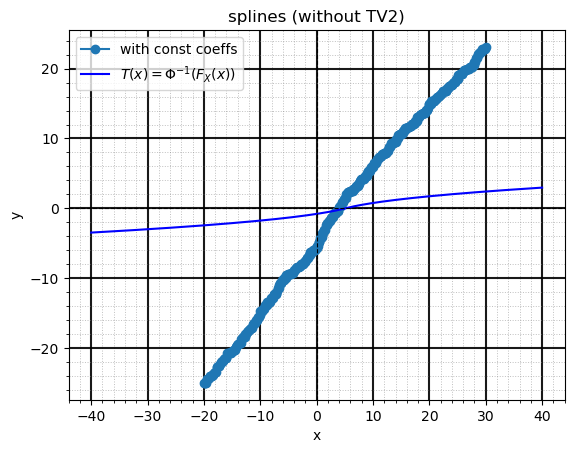

In [18]:
SIZE=401;RANGE=20; START_VAL=-20; END_VAL=30
#GRID_VALS= generate_unequally_spaced_sorted_numbers(start_val=START_VAL,end_val=END_VAL,N=SIZE)
GRID_VALS,FN_INIT = transformation_laplace_to_std_normal(mu=mean, b=scale, x_range=(START_VAL,END_VAL), num_points=SIZE)
noise = torch.randn_like(torch.tensor(FN_INIT)) * 2e-1
model2 = LinearSplineSlopeConstrained(
                mode='fc',
                num_activations=1,
                size=SIZE,# number of knots is size -2
                range_=RANGE,
                grid_values=torch.tensor(GRID_VALS),
                # grid_values=torch.tensor([-2.9132, -1.,  1.8,  2.1882,  2.9779]),
                init="manual",#"maxmin",# what if I try relu activation function?
                smin=0.001,
                smax=10,
                slope_constrained=1,
                manual_init_fn_tensor=torch.tensor(FN_INIT)+noise
) 
# print("constrained coefficients are: ",model2.slope_constrained_coefficients_vect)
# print(f"slopes: constrained coeffs: {model2.slopes_tensor(for_projected_coeffs=1)}")
# visualise the code space before the training
input_tensor = torch.tensor(train_data)
output_tensor2=model2(input_tensor)
# plot_multiple_histogram([input_tensor.numpy(), output_tensor2.detach().numpy()
#                         ],
#                         labels_list=["data_space (x)","code_space(z)"])

x2pos, y2pos = model2.nodal_val_loc_tensor.detach().numpy(), model2.slope_constrained_coefficients_vect.detach().numpy()
# print('grid vals and x2pos vals')
# print(GRID_VALS, x2pos)
# print('fn val and slope constrained fn val')
# print(FN_INIT, y2pos)
    # Add labels, title, and grid
    # plt.figure(figsize=(8,8))
plt.figure()
plot_with_annotations(x2pos[0][:], y2pos[:],
                    title="splines (without TV2)", xlabel="x", ylabel="y",
                    annotate=0, style='-o')
plt.legend()
plt.show()

In [19]:
# with torch.no_grad():
#    zz,gg=model2(torch.tensor([[-30.], [-20], [0.], [20], [30]])), model2.grad_x_temp
# zz,gg, zz**2

In [20]:
# training 100 rounds with low tv2 regularization
train_loss2, val_loss2, epoch_wise_param_list,coeffs_unconstrained_evol2, coeffs_const_evol2 = train_and_evaluate(
    model = model2,
    train_loader=train_loader,
    val_loader=val_loader, 
    num_epochs=12, 
    scheduler_type="ReduceLROnPlateau",
    lr=0.0005,#0.004
    print_after=1,   
    track_coefficients=1, #
    type_model="scls", 
    tv2_regulation= 1, 
    lambda_tv2=0.000065,#0.095, 
    gamma = 0.5, # schedular, learning rate decay factor
    alpha_nll=1# We don;t need any alpha anymore! get rid of this in the code later
) # why is it no # good thing is that it is shifting but the bad thing is that its kind of collapsing to 0 . NOT ANYMORE

Training Progress:   8%|▊         | 1/12 [01:35<17:34, 95.90s/it]

Epoch 1/12,  train NLL+6.5e-05XTV2: 28.713298897493143, data avg loss-1: 25.264485719746766 ,data avg loss-2: -3.4150698330357407 ,Training NLL Loss: 28.679555552782453, Validation NLL Loss: 20.44051750280667, LR: 0.0005


Training Progress:  17%|█▋        | 2/12 [03:12<16:00, 96.07s/it]

Epoch 2/12,  train NLL+6.5e-05XTV2: 14.772526479424272, data avg loss-1: 11.013643918684032 ,data avg loss-2: -3.735921589634575 ,Training NLL Loss: 14.749565508318605, Validation NLL Loss: 11.091666511211734, LR: 0.0005


Training Progress:  25%|██▌       | 3/12 [04:46<14:18, 95.40s/it]

Epoch 3/12,  train NLL+6.5e-05XTV2: 9.095475346459112, data avg loss-1: 5.369096407554015 ,data avg loss-2: -3.7109866018085254 ,Training NLL Loss: 9.080083009362525, Validation NLL Loss: 7.409132866195016, LR: 0.0005


Training Progress:  33%|███▎      | 4/12 [06:23<12:49, 96.14s/it]

Epoch 4/12,  train NLL+6.5e-05XTV2: 6.14909731273577, data avg loss-1: 2.6633600442583463 ,data avg loss-2: -3.475788824164904 ,Training NLL Loss: 6.139148868423242, Validation NLL Loss: 5.30173522351555, LR: 0.0005


Training Progress:  42%|████▏     | 5/12 [08:00<11:14, 96.40s/it]

Epoch 5/12,  train NLL+6.5e-05XTV2: 4.811325612570278, data avg loss-1: 1.5320560883035992 ,data avg loss-2: -3.2729657918413513 ,Training NLL Loss: 4.805021880144949, Validation NLL Loss: 4.425893972917608, LR: 0.0005


Training Progress:  50%|█████     | 6/12 [09:37<09:38, 96.49s/it]

Epoch 6/12,  train NLL+6.5e-05XTV2: 4.017594990617381, data avg loss-1: 0.9495774870336225 ,data avg loss-2: -3.0643839990513846 ,Training NLL Loss: 4.013961486085014, Validation NLL Loss: 3.776915137635928, LR: 0.0005


Training Progress:  58%|█████▊    | 7/12 [11:15<08:04, 96.83s/it]

Epoch 7/12,  train NLL+6.5e-05XTV2: 3.632058393111783, data avg loss-1: 0.765691600633953 ,data avg loss-2: -2.864136957634705 ,Training NLL Loss: 3.629828558268667, Validation NLL Loss: 3.5372853333406282, LR: 0.0005


Training Progress:  67%|██████▋   | 8/12 [12:51<06:26, 96.73s/it]

Epoch 8/12,  train NLL+6.5e-05XTV2: 3.4018419398554385, data avg loss-1: 0.6615973732049322 ,data avg loss-2: -2.7387130806735427 ,Training NLL Loss: 3.400310453878476, Validation NLL Loss: 3.3137893555924753, LR: 0.0005


Training Progress:  75%|███████▌  | 9/12 [14:27<04:49, 96.62s/it]

Epoch 9/12,  train NLL+6.5e-05XTV2: 3.2288053152960963, data avg loss-1: 0.6120035559232662 ,data avg loss-2: -2.6155998608225697 ,Training NLL Loss: 3.227603416745836, Validation NLL Loss: 3.2233934377395848, LR: 0.0005


Training Progress:  83%|████████▎ | 10/12 [16:03<03:12, 96.17s/it]

Epoch 10/12,  train NLL+6.5e-05XTV2: 3.1593977080796023, data avg loss-1: 0.5672187822438116 ,data avg loss-2: -2.5911935755805153 ,Training NLL Loss: 3.1584123578243246, Validation NLL Loss: 3.1000787454977554, LR: 0.0005


Training Progress:  92%|█████████▏| 11/12 [17:39<01:36, 96.33s/it]

Epoch 11/12,  train NLL+6.5e-05XTV2: 3.1084736941985445, data avg loss-1: 0.5392237054717816 ,data avg loss-2: -2.568334944688242 ,Training NLL Loss: 3.1075586501600103, Validation NLL Loss: 3.0518370094063054, LR: 0.0005


Training Progress: 100%|██████████| 12/12 [19:15<00:00, 96.32s/it]

Epoch 12/12,  train NLL+6.5e-05XTV2: 3.017490554018716, data avg loss-1: 0.5236667472177007 ,data avg loss-2: -2.49294443287115 ,Training NLL Loss: 3.0166111800888524, Validation NLL Loss: 3.0073801458585443, LR: 0.0005
Training complete


In [21]:
# plot different plots to visualise the training dynamics
def analyse_training(model_in, test_data,train_loss, val_loss,model_params_list,
                    num_coeffs ,figsize=(12,12),num_samples=20000,
                    print_model_params=0, plot_freq=5
                    ):
    input_tensor = torch.tensor(test_data)
    output_tensor2 = model_in(input_tensor)
    plot_multiple_histogram([input_tensor.numpy(), output_tensor2.detach().numpy()],
                            labels_list=["original_space (x)", "code_space(z)"])

    plot_loss_curves(train_loss=train_loss, val_loss=val_loss,
                    title="linear-spline model slope constrained", log_scale=1)

    x2pos, y2pos = model_in.nodal_val_loc_tensor.detach().numpy(), model_in.slope_constrained_coefficients_vect.detach().numpy()
    # Add labels, title, and grid
    # plt.figure(figsize=(8,8))
    
    plot_with_annotations(x2pos[0][:], y2pos[:],
                        title="splines (without TV2)", xlabel="x", ylabel="y", annotate=0, style="-*")
    plt.legend()
    plt.show()
    ## 
    #print(f"slopes: constrained coeffs: {model_in.slopes_tensor(for_projected_coeffs=1)}")
    #plot_coefficients_evolution(num_coeffs,
    #                            np.array(coeffs_unconstrained_evol2), 
    #                            np.array(coeffs_const_evol2), log_scale=0)
    
    model = LinearSplineSlopeConstrained(
                        mode='fc',
                        num_activations=1,
                        size=SIZE,# number of knots is size -2
                        range_=RANGE,
                        grid_values=model_in.nodal_val_loc_tensor.detach().reshape(-1),
                        init="maxmin",#"maxmin",# what if I try relu activation function?
                        smin=0.001,
                        smax=10,
                        slope_constrained=1
) 
    
    plot_multiple_z_with_normal_1d(models_params=model_params_list,test_data=test_data,
                                model=model,figsize=figsize, num_samples=num_samples,
                                print_model_params=print_model_params, plot_frequency=plot_freq)


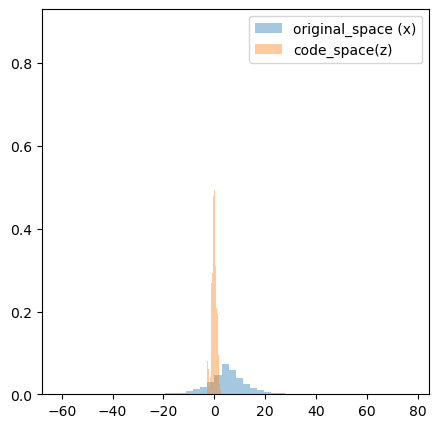

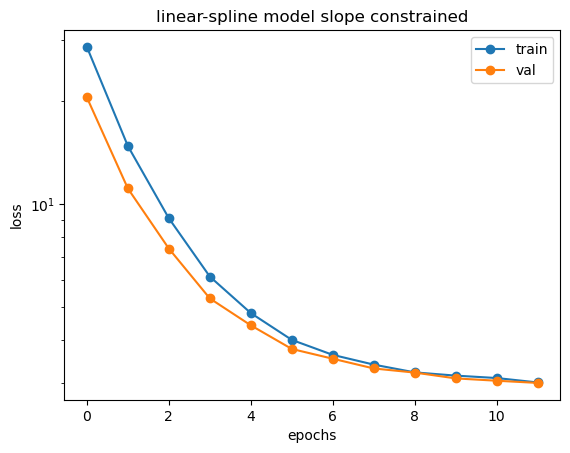

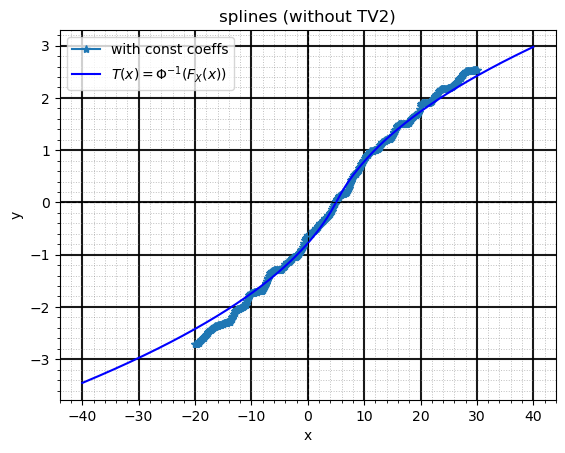

/home/neel/Desktop/Lipschitz_DSNN/activations/linearspline_slope_constraint.py:208: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.nodal_val_loc_tensor = torch.tensor(grid_values).expand((num_activations, size))


initial nodal_val_locs: tensor([[-20.0000, -19.8750, -19.7500, -19.6250, -19.5000, -19.3750, -19.2500,
         -19.1250, -19.0000, -18.8750, -18.7500, -18.6250, -18.5000, -18.3750,
         -18.2500, -18.1250, -18.0000, -17.8750, -17.7500, -17.6250, -17.5000,
         -17.3750, -17.2500, -17.1250, -17.0000, -16.8750, -16.7500, -16.6250,
         -16.5000, -16.3750, -16.2500, -16.1250, -16.0000, -15.8750, -15.7500,
         -15.6250, -15.5000, -15.3750, -15.2500, -15.1250, -15.0000, -14.8750,
         -14.7500, -14.6250, -14.5000, -14.3750, -14.2500, -14.1250, -14.0000,
         -13.8750, -13.7500, -13.6250, -13.5000, -13.3750, -13.2500, -13.1250,
         -13.0000, -12.8750, -12.7500, -12.6250, -12.5000, -12.3750, -12.2500,
         -12.1250, -12.0000, -11.8750, -11.7500, -11.6250, -11.5000, -11.3750,
         -11.2500, -11.1250, -11.0000, -10.8750, -10.7500, -10.6250, -10.5000,
         -10.3750, -10.2500, -10.1250, -10.0000,  -9.8750,  -9.7500,  -9.6250,
          -9.5000,  -9.3750,

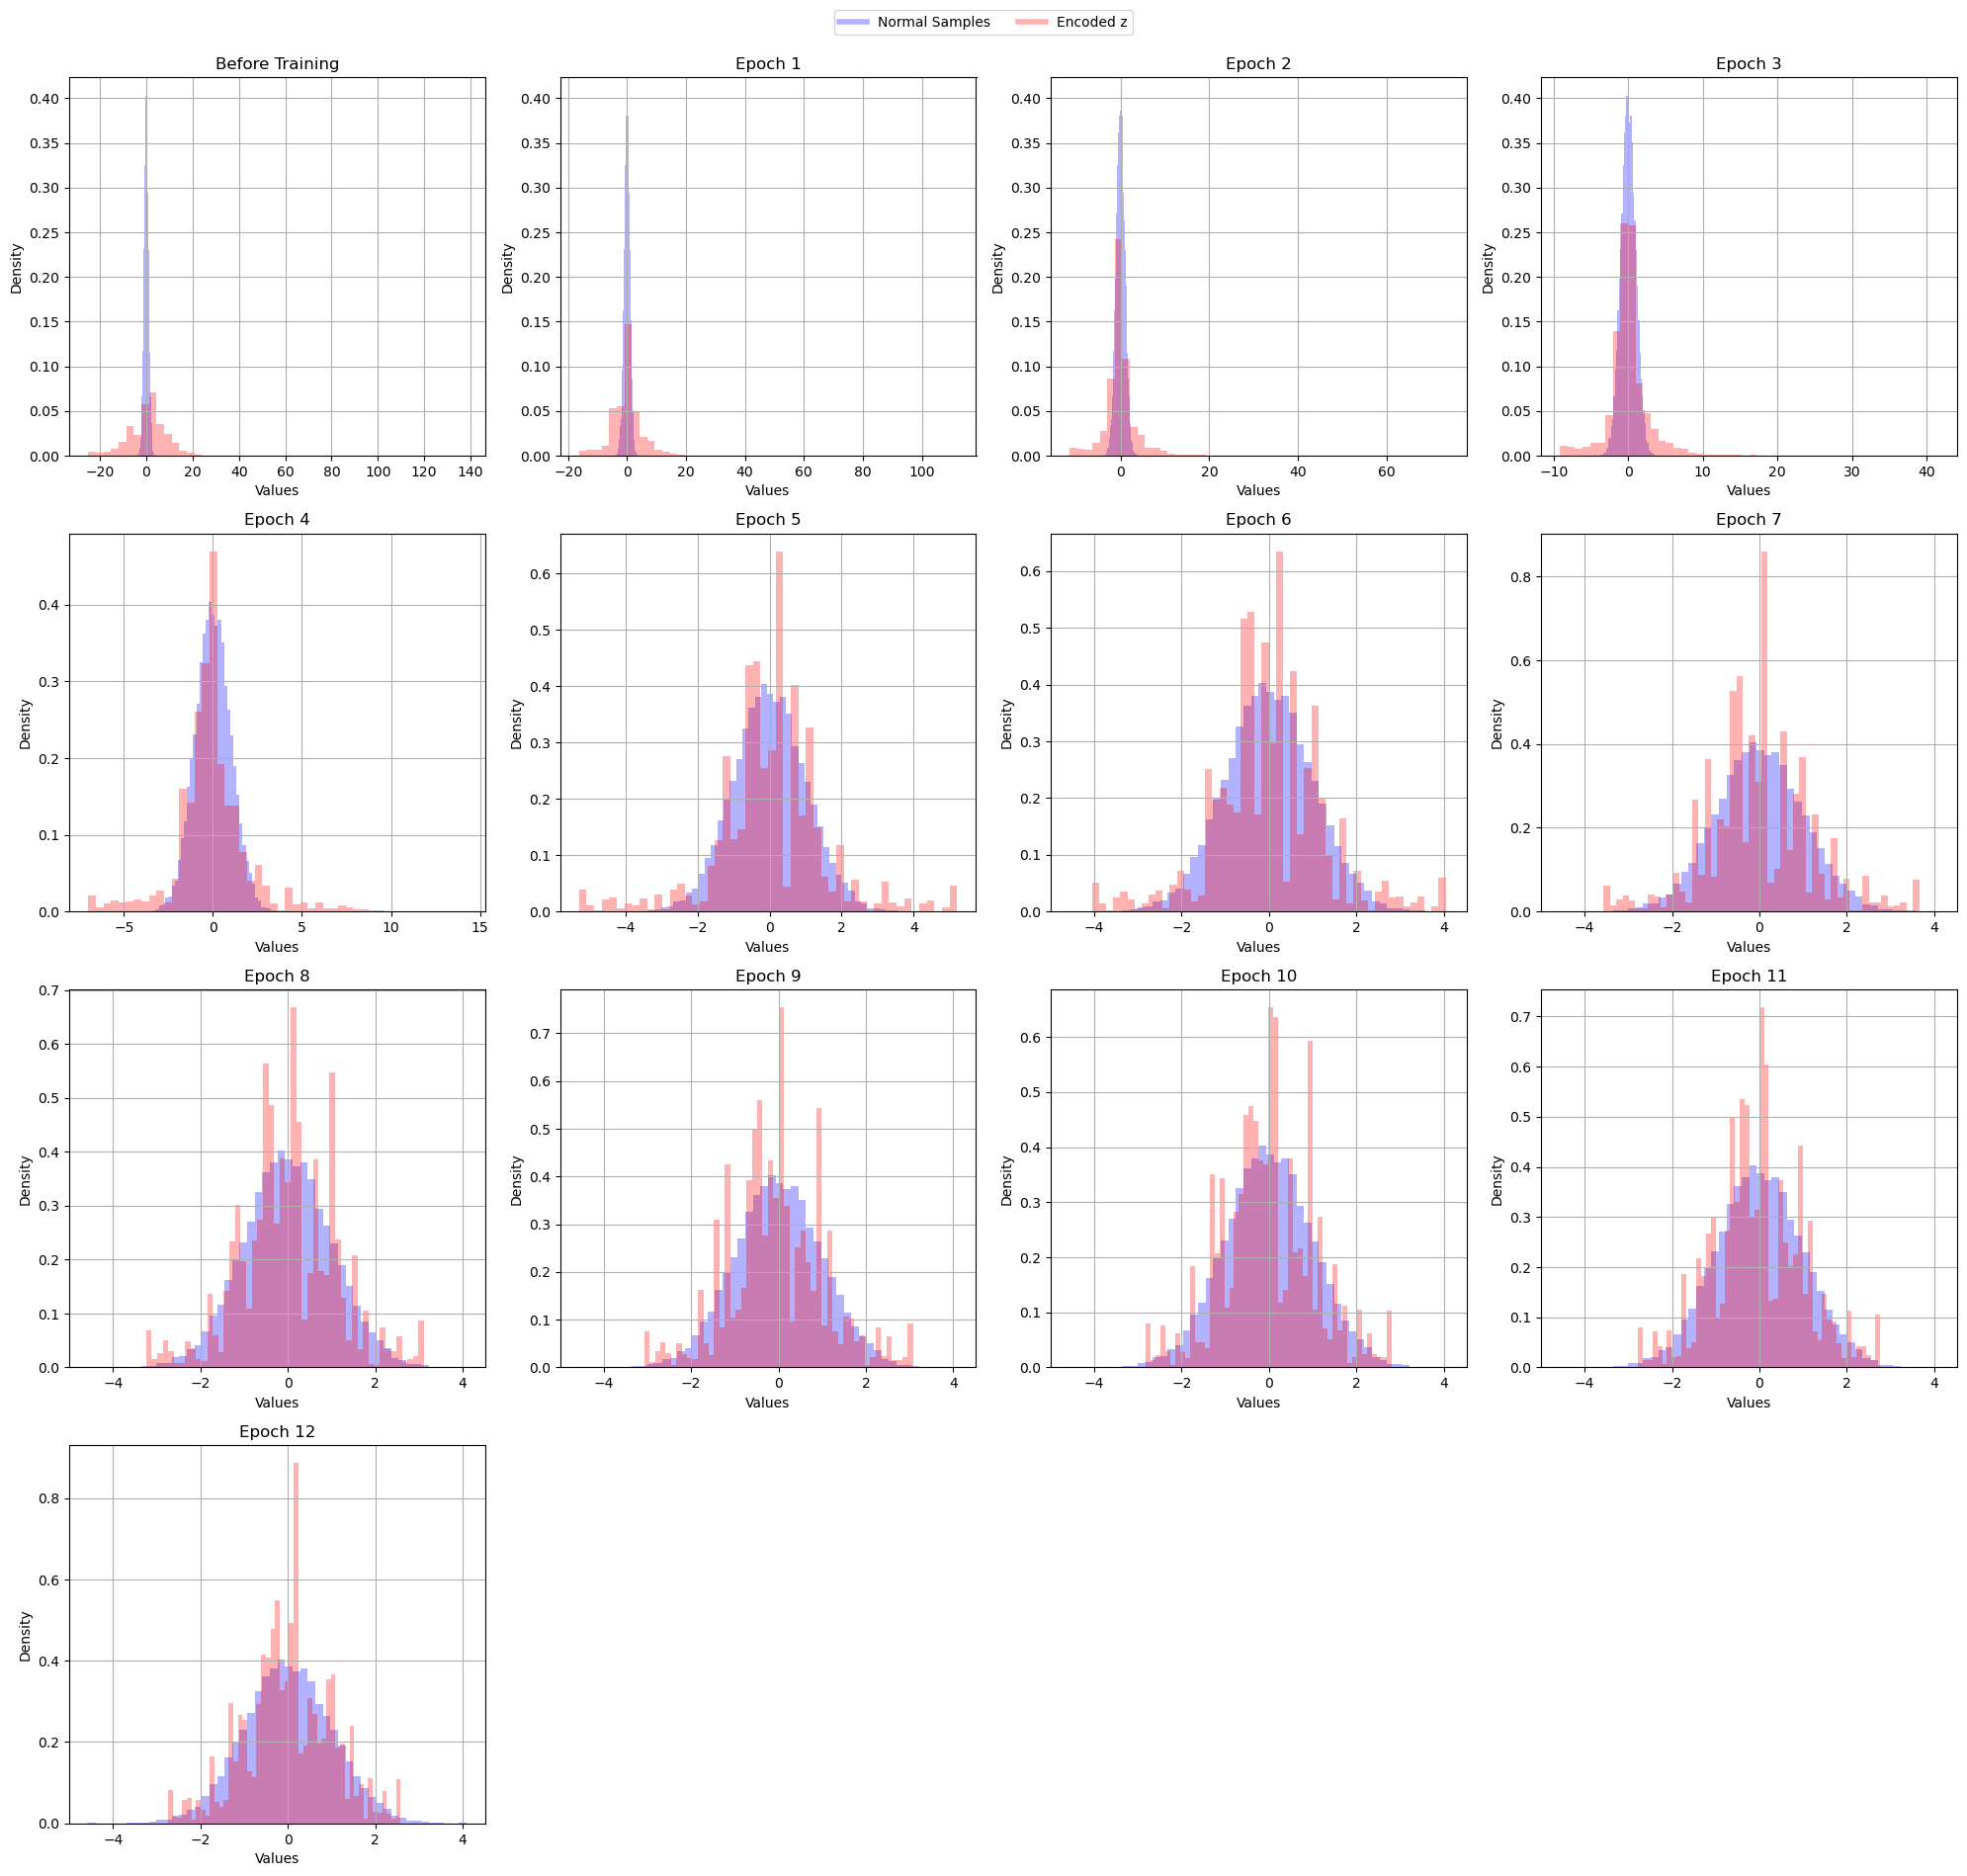

In [22]:
analyse_training(model_in=model2, 
train_loss=train_loss2, val_loss=val_loss2, 
                test_data=test_data, figsize=(20,20),
                model_params_list=epoch_wise_param_list,
                num_coeffs=10,print_model_params=0, plot_freq=1) # 40 more (30 below+40 x3 below + 40  more= 70+40+40 + 40=110+40 +40=150+40=190)

In [23]:
# from scipy.interpolate import CubicSpline

In [24]:
# def create_spline_interpolator(x, y, kind='cubic'):
#     """
#     Creates an interpolation function based on given x and y values.
    
#     Parameters:
#     - x: array-like, input x values.
#     - y: array-like, corresponding y values.
#     - kind: str, type of interpolation ('linear', 'quadratic', 'cubic').
    
#     Returns:
#     - interp_function: function that takes new x values and returns interpolated y values.
#     """
#     if kind == 'cubic':
#         interp_function = CubicSpline(x, y)
#     else:
#         from scipy.interpolate import interp1d
#         interp_function = interp1d(x, y, kind=kind, fill_value="extrapolate")
    
#     return interp_function  # This function can now be used for new x values

In [25]:
# xdata, ydata = model2.nodal_val_loc_tensor.detach().numpy(), model2.slope_constrained_coefficients_vect.detach().numpy()

In [26]:
# from scipy.interpolate import interp1d, CubicSpline

# def create_spline_interpolators(x, y):
#     """
#     Creates linear, quadratic, and cubic spline interpolators.

#     Parameters:
#     - x: array-like, input x values.
#     - y: array-like, corresponding y values.

#     Returns:
#     - Dictionary containing interpolation functions for each kind.
#     """
#     inter_fns = {
#         'linear': interp1d(x, y, kind='linear', fill_value="extrapolate"),
#         'quadratic': interp1d(x, y, kind='quadratic', fill_value="extrapolate"),
#         'cubic': CubicSpline(x, y)  # Equivalent to interp1d with kind='cubic'
#     }
#     return inter_fns

# # Get interpolators
# interpolators = create_spline_interpolators(xdata[0], ydata)

# # Generate dense x values for smooth plotting
# x_dense = np.linspace(xdata.min() - 0.5, xdata.max() + 0.5, 200)

# # Compute interpolated values for each method
# y_linear = interpolators['linear'](x_dense)
# y_quadratic = interpolators['quadratic'](x_dense)
# y_cubic = interpolators['cubic'](x_dense)

# # Create subplots
# fig, axes = plt.subplots(3, 1, figsize=(7, 7), sharex=True)

# # Linear Spline
# axes[0].plot(xdata[0], ydata, 'o', label='Data Points', markersize=8)
# axes[0].plot(x_dense, y_linear, '-', label='Linear Spline', linewidth=1.5)
# axes[0].set_ylabel("Interpolated y")
# axes[0].set_title("Linear Spline")
# axes[0].legend()
# axes[0].grid(True)

# # Quadratic Spline
# axes[1].plot(xdata[0], ydata, 'o', label='Data Points', markersize=8)
# axes[1].plot(x_dense, y_quadratic, '-', label='Quadratic Spline', linewidth=1.5)
# axes[1].set_ylabel("Interpolated y")
# axes[1].set_title("Quadratic Spline")
# axes[1].legend()
# axes[1].grid(True)

# # Cubic Spline
# axes[2].plot(xdata[0], ydata, 'o', label='Data Points', markersize=8)
# axes[2].plot(x_dense, y_cubic, '-', label='Cubic Spline', linewidth=2)
# axes[2].set_xlabel("x")
# axes[2].set_ylabel("Interpolated y")
# axes[2].set_title("Cubic Spline")
# axes[2].legend()
# axes[2].grid(True)

# # Adjust layout
# plt.tight_layout()
# plt.show()


In [27]:
# interpolators

In [28]:
# y_lin, y_quad, y_cubic = interpolators['linear'](test_data), interpolators['quadratic'](test_data), interpolators['cubic'](test_data)
# with torch.no_grad():
#     model_op = model2(torch.tensor(test_data, dtype=torch.float))

In [29]:
# plot_multiple_histogram([np.random.normal(0, 1, num_samples), 
#                         y_lin,
#                         model_op.squeeze().numpy()
#                         ],
#                         labels_list=["normal", 
#                                      "linear",
#                                      "model output"
#                                      ])

In [23]:
# 2ND TIME training 100 more rounds but with different tv2 regul strength (further reduced a bit)
train_loss2, val_loss2, epoch_wise_param_list,coeffs_unconstrained_evol2, coeffs_const_evol2 = train_and_evaluate(
    model = model2,
    train_loader=train_loader,
    val_loader=val_loader, 
    num_epochs=6, 
    scheduler_type="ReduceLROnPlateau",
    lr=0.0005,#0.004
    print_after=1,   
    track_coefficients=1, #
    type_model="scls", 
    tv2_regulation= 1, 
    lambda_tv2=0.000065,#0.095, 
    gamma = 0.5, # schedular, learning rate decay factor
    alpha_nll=1# We don;t need any alpha anymore! get rid of this in the code later
) 

Training Progress:  17%|█▋        | 1/6 [01:36<08:02, 96.55s/it]

Epoch 1/6,  train NLL+6.5e-05XTV2: 2.9967487890056317, data avg loss-1: 0.5152362988315347 ,data avg loss-2: -2.4806075081165173 ,Training NLL Loss: 2.995843806948054, Validation NLL Loss: 2.9840526107780674, LR: 0.0005


Training Progress:  33%|███▎      | 2/6 [03:13<06:26, 96.64s/it]

Epoch 2/6,  train NLL+6.5e-05XTV2: 2.9994667635095, data avg loss-1: 0.4960378826972745 ,data avg loss-2: -2.5025720988107483 ,Training NLL Loss: 2.9986099815080127, Validation NLL Loss: 3.0297985722850678, LR: 0.0005


Training Progress:  50%|█████     | 3/6 [04:50<04:51, 97.12s/it]

Epoch 3/6,  train NLL+6.5e-05XTV2: 2.954850496910002, data avg loss-1: 0.4718192230771345 ,data avg loss-2: -2.4822671468166018 ,Training NLL Loss: 2.954086369893735, Validation NLL Loss: 2.9389950054818677, LR: 0.0005


Training Progress:  67%|██████▋   | 4/6 [06:27<03:13, 96.89s/it]

Epoch 4/6,  train NLL+6.5e-05XTV2: 2.9435636064421993, data avg loss-1: 0.4683438307449596 ,data avg loss-2: -2.474432867842723 ,Training NLL Loss: 2.9427766985876875, Validation NLL Loss: 2.933286825086971, LR: 0.0005


Training Progress:  83%|████████▎ | 5/6 [08:05<01:37, 97.18s/it]

Epoch 5/6,  train NLL+6.5e-05XTV2: 2.887570820440157, data avg loss-1: 0.4536226724770639 ,data avg loss-2: -2.433107124322233 ,Training NLL Loss: 2.886729796799295, Validation NLL Loss: 2.9415605901341197, LR: 0.0005


Training Progress: 100%|██████████| 6/6 [09:42<00:00, 97.02s/it]

Epoch 6/6,  train NLL+6.5e-05XTV2: 2.914526155812488, data avg loss-1: 0.44205281025627735 ,data avg loss-2: -2.4717318456023296 ,Training NLL Loss: 2.913784655858607, Validation NLL Loss: 2.948302346849823, LR: 0.0005
Training complete


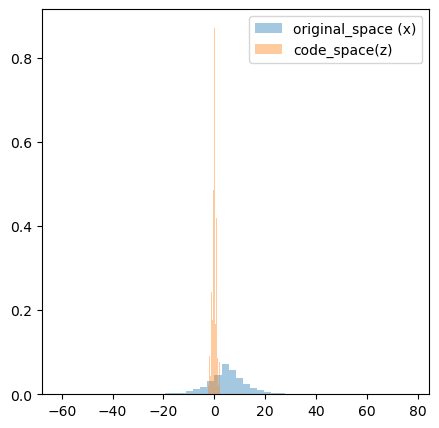

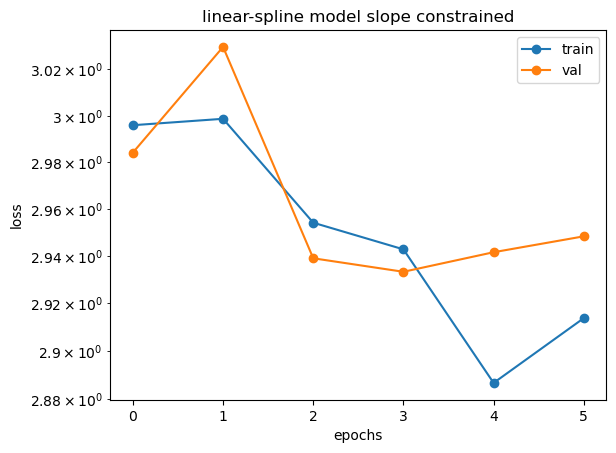

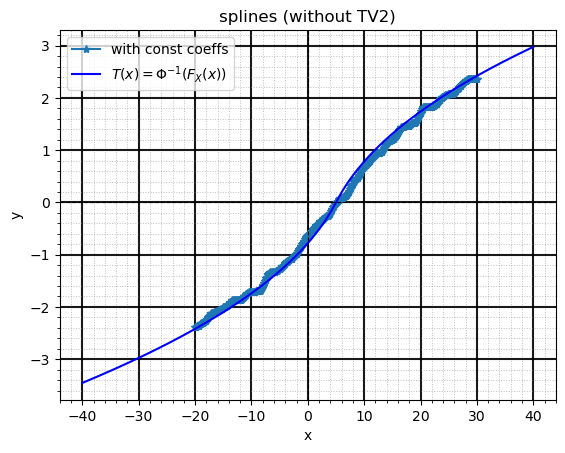

initial nodal_val_locs: tensor([[-20.0000, -19.8750, -19.7500, -19.6250, -19.5000, -19.3750, -19.2500,
         -19.1250, -19.0000, -18.8750, -18.7500, -18.6250, -18.5000, -18.3750,
         -18.2500, -18.1250, -18.0000, -17.8750, -17.7500, -17.6250, -17.5000,
         -17.3750, -17.2500, -17.1250, -17.0000, -16.8750, -16.7500, -16.6250,
         -16.5000, -16.3750, -16.2500, -16.1250, -16.0000, -15.8750, -15.7500,
         -15.6250, -15.5000, -15.3750, -15.2500, -15.1250, -15.0000, -14.8750,
         -14.7500, -14.6250, -14.5000, -14.3750, -14.2500, -14.1250, -14.0000,
         -13.8750, -13.7500, -13.6250, -13.5000, -13.3750, -13.2500, -13.1250,
         -13.0000, -12.8750, -12.7500, -12.6250, -12.5000, -12.3750, -12.2500,
         -12.1250, -12.0000, -11.8750, -11.7500, -11.6250, -11.5000, -11.3750,
         -11.2500, -11.1250, -11.0000, -10.8750, -10.7500, -10.6250, -10.5000,
         -10.3750, -10.2500, -10.1250, -10.0000,  -9.8750,  -9.7500,  -9.6250,
          -9.5000,  -9.3750,

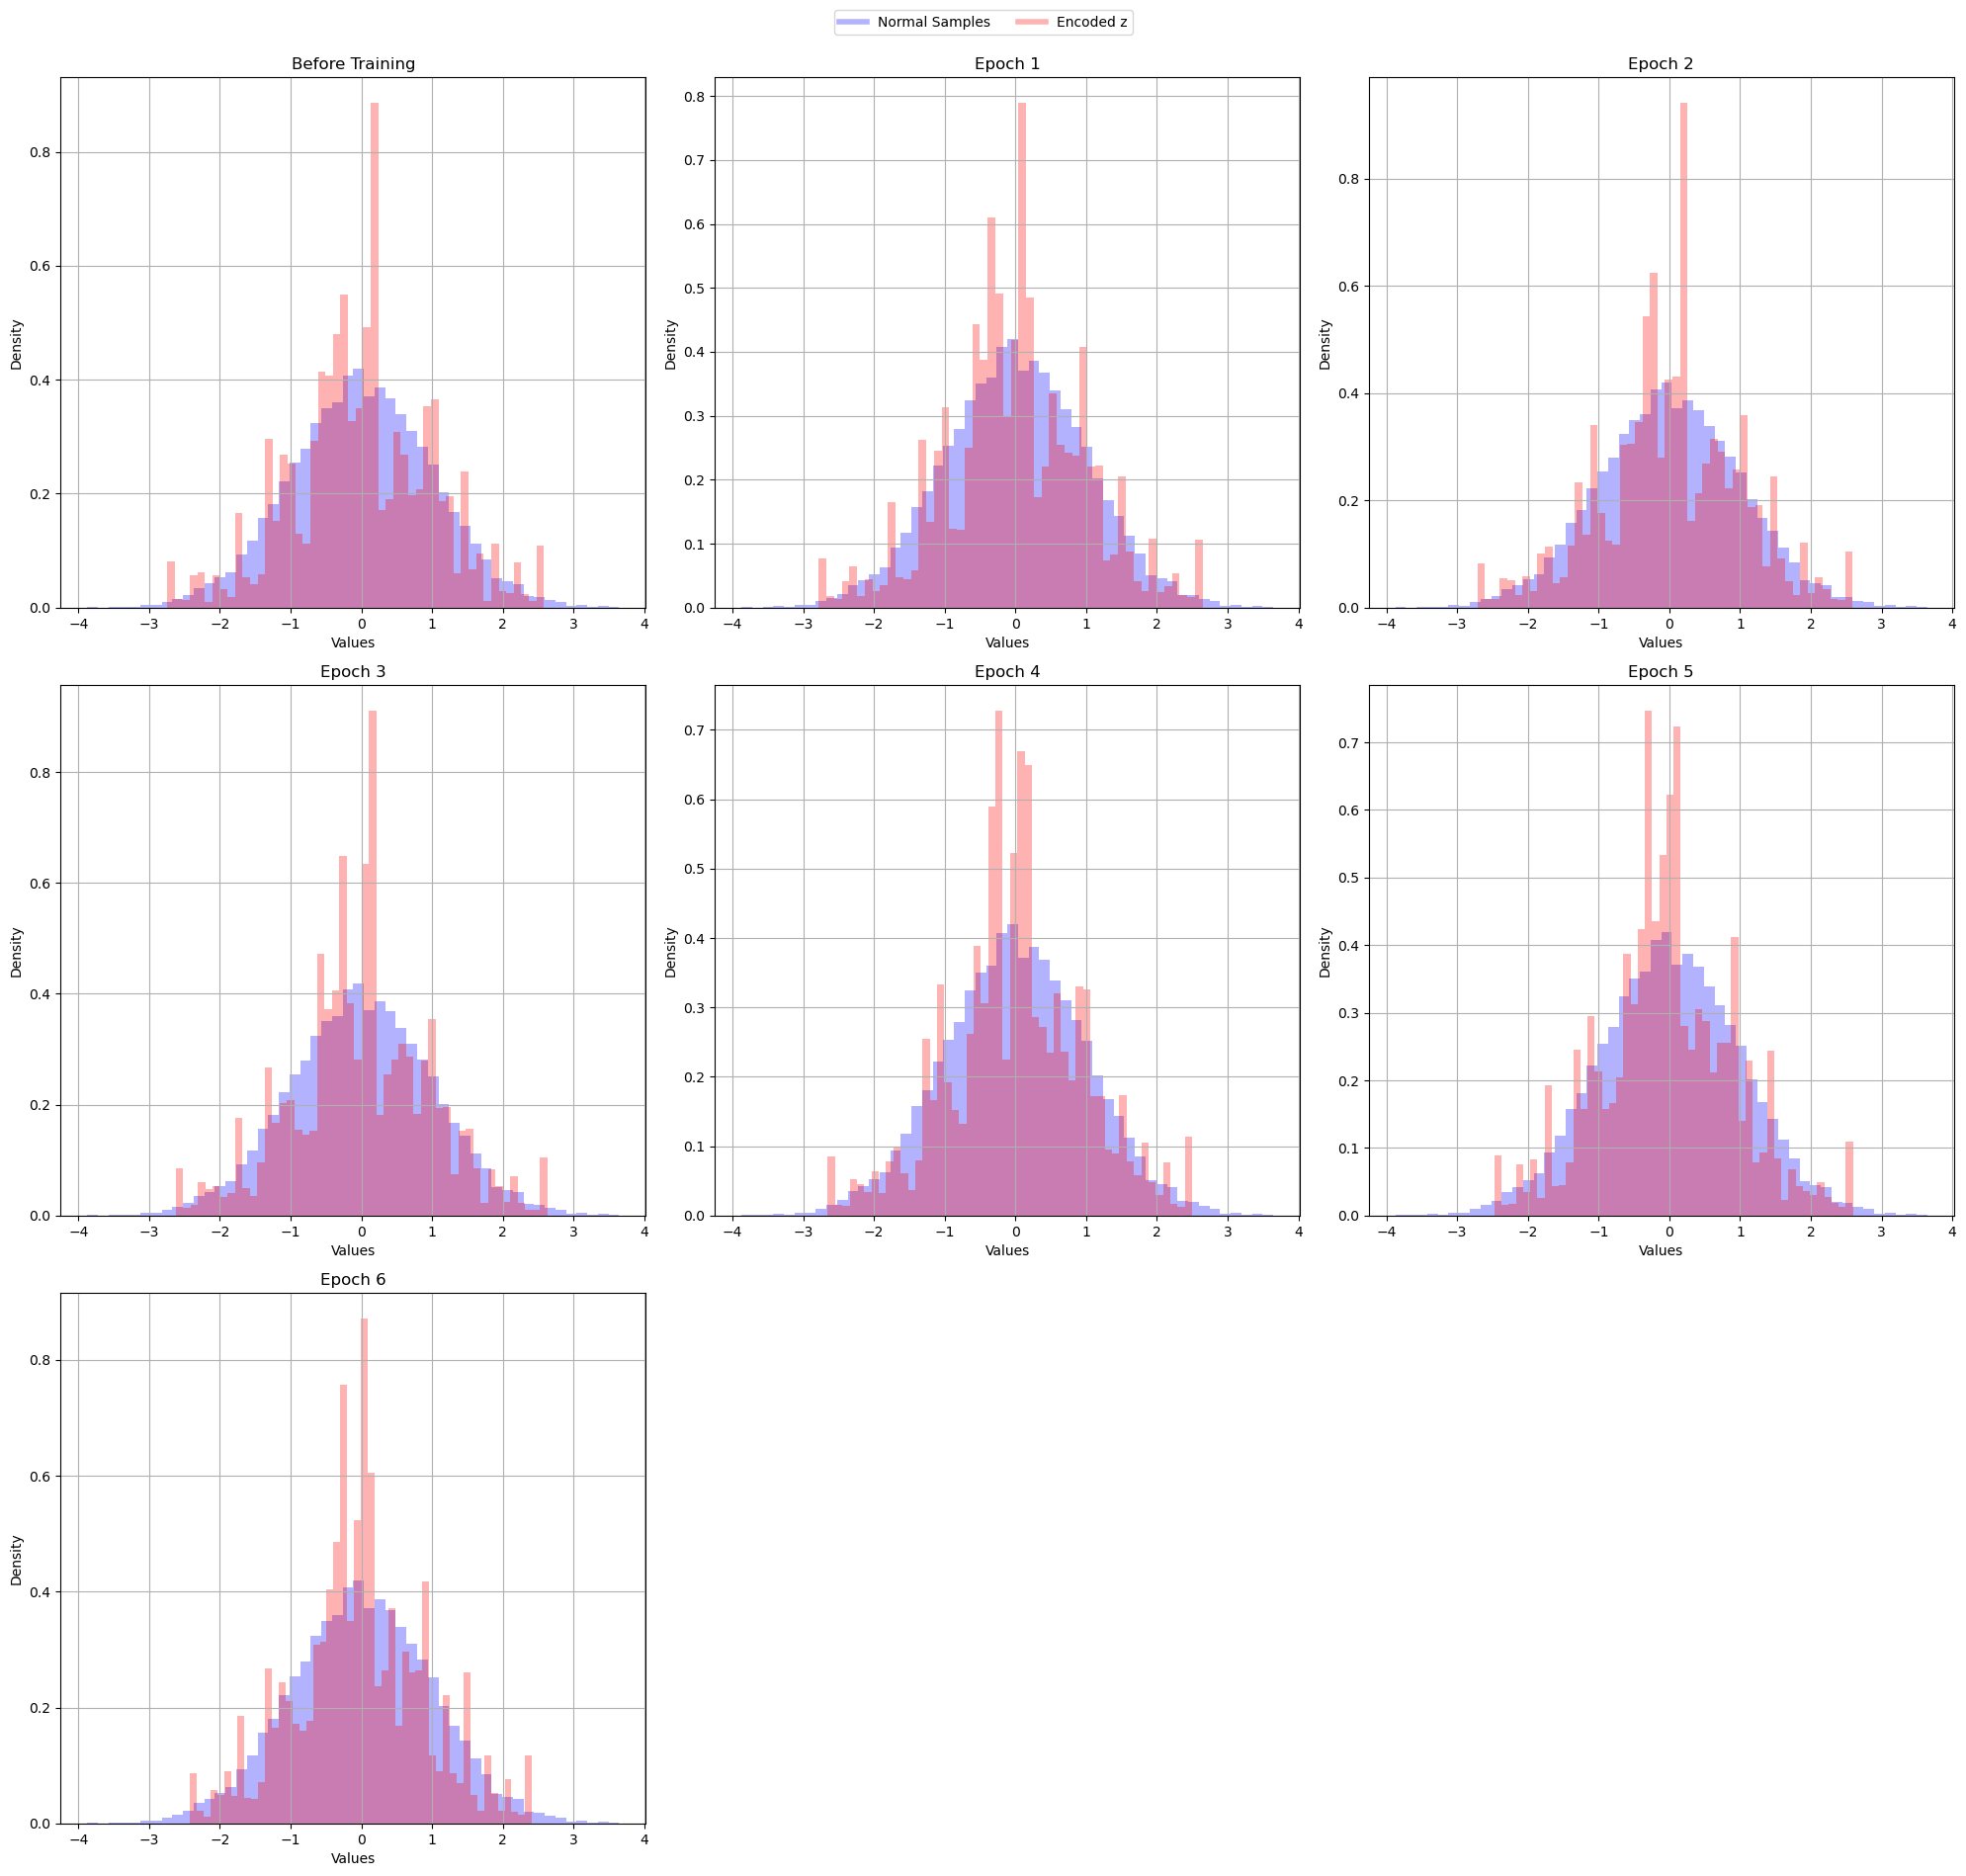

In [24]:
analyse_training(model_in=model2,
train_loss=train_loss2, val_loss=val_loss2, 
                test_data=test_data, figsize=(20,20),
                model_params_list=epoch_wise_param_list,
                num_coeffs=10,print_model_params=0, plot_freq=1) # 40 more (30 below+40 x3 below + 40  more= 70+40+40 + 40=110+40 +40=150+40=190)